In [1]:
import ee
ee.Initialize()

import geemap
import pandas as pd
import geopandas as gpd
import numpy as np 

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

pd.options.display.float_format = '{:.3f}'.format

## 1 - input parameters

In [2]:
ISO = 'CMR'

In [3]:
lc_image = ee.Image('projects/ee-cocoacmr/assets/land_cover/CMR_land_cover_2020')

In [4]:
# resolution of the map
scale = 10

In [5]:
# band name for classification
lc_band = 'LC_2020'

In [6]:
# list of class codes
lc_labels = [11,12,13,14,15,21,22,30,41,42,50,60]

In [7]:
# CEO data
interpretedData = pd.read_csv('/home/sepal-user/cocoa-CMR/CMR_LC_validated.csv', low_memory=False)
interpretedData.columns

Index(['index', 'plotid', 'sampleid', 'sample_internal_id', 'lon', 'lat',
       'flagged', 'collection_time', 'sample_geom', 'pl_index', 'pl_jrcmap',
       'pl_tcc', 'IPCC_Ref', 'FType_2020_Ref', 'AgType_2020_Ref',
       'HumType_2020_Ref', 'collection', 'interpreted', 'IPCC_2020_Code_Ref',
       'FNF_2020_Ref', 'FType_2020_Code_Ref', 'AgType_2020_Code_Ref',
       'HumType_2020_Code_Ref', 'LC_2020_Code_Ref'],
      dtype='object')

In [8]:
len(interpretedData)

2417

In [9]:
# column with LC code
lc_ref_column = 'LC_2020_Code_Ref'

In [42]:
table_out = '/home/sepal-user/cocoa-CMR/CMR_2020_LC_types_ceo.csv'

### 2 get map areas

In [10]:
aoi = ee.FeatureCollection('projects/ee-cocoacmr/assets/admin/cmr_admbnda_adm0')

In [11]:
# Add the area for each pixel
pixelArea = ee.Image.pixelArea().clip(aoi)
# Multiply pixel area by the class to get the area per class
area_image = pixelArea.addBands(lc_image)

In [12]:
# Reduce the region by summing up the areas per class
class_areas = area_image.reduceRegion(
    reducer=ee.Reducer.sum().group(groupField=1, groupName='class'),
    geometry=lc_image.geometry(),
    scale=30,  # Adjust scale according to your image resolution
    maxPixels=1e12
)

In [13]:
# Assuming class_areas is already defined and contains the necessary data
class_areas_dict = class_areas.getInfo()

# Prepare the data for the DataFrame
data = []
for item in class_areas_dict['groups']:
    area_ha = item['sum'] / 10000  # Convert square meters to hectares
    data.append({
        'Class': item['class'],
        'Area (ha)': area_ha
    })

# Convert the list of dictionaries to a DataFrame
lc_areas_df = pd.DataFrame(data)

# Display the DataFrame
print(lc_areas_df)

    Class    Area (ha)
0      11 26974598.288
1      12  1549311.145
2      13   405393.101
3      14   211844.912
4      15  3674169.983
5      21   129214.201
6      22  3614096.723
7      30  8477336.158
8      41   466601.506
9      42   348985.447
10     50   238600.098
11     60   564229.013


### 3 - sample map with validation points 

In [14]:
gdf = gpd.GeoDataFrame(interpretedData[['index', 'plotid', 'sampleid', 'collection', 
        'LC_2020_Code_Ref', 'lon', 'lat']], geometry=gpd.points_from_xy(interpretedData.lon, interpretedData.lat), crs='epsg:4326')
gdf

,index,plotid,sampleid,collection,LC_2020_Code_Ref,lon,lat,geometry
0,0,2,2,1,30,13.157,9.445,POINT (13.15682 9.44489)
1,1,4,4,1,12,14.299,7.777,POINT (14.29857 7.77672)
2,2,7,7,1,30,14.741,11.144,POINT (14.74055 11.1445)
3,3,6,6,1,30,13.760,8.647,POINT (13.75959 8.64718)
4,4,8,8,1,11,13.101,4.403,POINT (13.10112 4.40264)
...,...,...,...,...,...,...,...,...
2412,2412,1994,1994,6,22,14.563,11.449,POINT (14.5629 11.44925)
2413,2413,1927,1927,6,22,13.865,10.371,POINT (13.86491 10.37083)
2414,2414,1985,1985,6,22,13.137,9.016,POINT (13.13737 9.01635)
2415,2415,1920,1920,6,15,11.046,4.097,POINT (11.04591 4.09708)


##### be patient this can take a while with a large number of points

In [15]:
dfs = []
for i in range(0, len(interpretedData), 5000):
    tmp_df = gdf.loc[i:i+4999]
    tmp_fc = geemap.gdf_to_ee(tmp_df[['index','plotid', 'sampleid', 'collection','LC_2020_Code_Ref', 'geometry']])
    tmp_smp = lc_image.select(lc_band).reduceRegions(**{
        'collection': tmp_fc,
        'scale': scale,
        'reducer': ee.Reducer.first()   
    })

    tmp_res = geemap.ee_to_gdf(tmp_smp)
    dfs.append(tmp_res)
    
results_df = pd.concat(dfs)

In [16]:
lc_map_column = 'LC_2020_Code_Map'
lc_results_df = results_df.rename(columns={'first':lc_map_column})
lc_results_df

,geometry,LC_2020_Code_Ref,collection,LC_2020_Code_Map,index,plotid,sampleid
0,POINT (13.15682 9.44489),30,1,30.000,0,2,2
1,POINT (14.29857 7.77672),12,1,11.000,1,4,4
2,POINT (14.74055 11.1445),30,1,30.000,2,7,7
3,POINT (13.75959 8.64718),30,1,30.000,3,6,6
4,POINT (13.10112 4.40264),11,1,11.000,4,8,8
...,...,...,...,...,...,...,...
2412,POINT (14.5629 11.44925),22,6,41.000,2412,1994,1994
2413,POINT (13.86491 10.37083),22,6,22.000,2413,1927,1927
2414,POINT (13.13737 9.01635),22,6,22.000,2414,1985,1985
2415,POINT (11.04591 4.09708),15,6,13.000,2415,1920,1920


In [17]:
print(lc_results_df.columns)

Index(['geometry', 'LC_2020_Code_Ref', 'collection', 'LC_2020_Code_Map',
       'index', 'plotid', 'sampleid'],
      dtype='object')


In [40]:
lc_results_df['LC_2020_Code_Map'] = lc_results_df['LC_2020_Code_Map'].fillna(0).astype(int)

In [43]:
#export table with map and reference
lc_results_df.to_csv(table_out,index=False)

#### Confusion matrix

In [20]:
clean_df = lc_results_df.dropna(subset=[lc_ref_column, lc_map_column])
conf_matrix = confusion_matrix(clean_df[lc_ref_column], clean_df[lc_map_column], labels=lc_labels)

In [22]:
# Calculate F1 score per class (individual F1 scores for each class)
f1_per_class = f1_score(clean_df[lc_ref_column], clean_df[lc_map_column], labels=lc_labels, average=None)

# Print F1 score per class
print("F1 score per class:")
for i, class_label in enumerate(lc_labels):
    print(f"Class {class_label}: {f1_per_class[i]:.4f}")

# Optionally, also print the macro and weighted F1 scores
f1_macro = f1_score(clean_df[lc_ref_column], clean_df[lc_map_column], labels=lc_labels, average='macro')
f1_weighted = f1_score(clean_df[lc_ref_column], clean_df[lc_map_column], labels=lc_labels, average='weighted')

print(f"\nMacro F1-score: {f1_macro:.4f}")  # Unweighted mean F1-score for all classes
print(f"Weighted F1-score: {f1_weighted:.4f}")  # Weighted by support (number of true instances per class)

F1 score per class:
Class 11: 0.7878
Class 12: 0.1867
Class 13: 0.1221
Class 14: 0.9231
Class 15: 0.4358
Class 21: 0.5714
Class 22: 0.5499
Class 30: 0.7100
Class 41: 0.4889
Class 42: 0.8116
Class 50: 0.7634
Class 60: 0.4337

Macro F1-score: 0.5654
Weighted F1-score: 0.6168


In [23]:
cm_df = pd.DataFrame(conf_matrix, index=lc_labels, columns=lc_labels)
print(cm_df)

     11  12  13  14  15  21   22   30  41  42  50  60
11  735   3   0   1  74   1    4    8   0   0   0   0
12  127  28   3   0  19   1    0   22   1   0   0   2
13   84  23  13   0   7   0    6   53   1   0   0   0
14    0   0   0  18   0   0    0    1   0   0   0   0
15   44   6   3   0  73   1    2   17   0   0   0   1
21    2   0   0   0   1   8    1    2   0   0   0   1
22    0   0   0   0   2   1  102   43   4   0   0   4
30   39  36   6   0   5   1   86  464  12   0   2  19
41    4   0   1   1   5   0    3    4  22   2   0   4
42    0   0   0   0   0   0    1    2   3  28   0   5
50    4   1   0   0   2   0    7   14   1   0  50   0
60    1   0   0   0   0   0    3    7   0   0   0  18


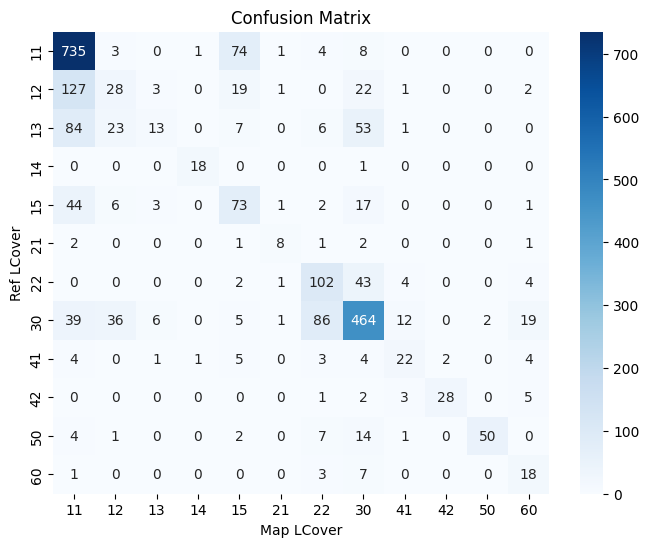

In [24]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Ref LCover')
plt.xlabel('Map LCover')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Select the column from areas_df to use for multiplication, for example, 'Area1'
area_column = lc_areas_df['Area (ha)']

In [26]:
# Convert the selected column to a NumPy array for broadcasting
area_column = area_column.to_numpy()

In [27]:
# Perform element-wise multiplication using broadcasting
weighted_conf_matrix = conf_matrix * area_column[:, np.newaxis]
weighted_conf_matrix

array([[1.98263297e+10, 8.09237949e+07, 0.00000000e+00, 2.69745983e+07,
        1.99612027e+09, 2.69745983e+07, 1.07898393e+08, 2.15796786e+08,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.96762515e+08, 4.33807121e+07, 4.64793343e+06, 0.00000000e+00,
        2.94369118e+07, 1.54931114e+06, 0.00000000e+00, 3.40848452e+07,
        1.54931114e+06, 0.00000000e+00, 0.00000000e+00, 3.09862229e+06],
       [3.40530205e+07, 9.32404132e+06, 5.27011031e+06, 0.00000000e+00,
        2.83775170e+06, 0.00000000e+00, 2.43235860e+06, 2.14858343e+07,
        4.05393101e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.81320842e+06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.11844912e+05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.61663479e+08, 2.20450199e+07, 1.10225099e+07, 0.00000000e+00,
        2.68214409e+08, 3.67416998e+06, 7.34833997e+06, 6.24

In [28]:
# Calculate overall accuracy
overall_accuracy = np.trace(weighted_conf_matrix) / np.sum(weighted_conf_matrix)
overall_accuracy

0.8293669335132676

In [29]:
# Calculate user's accuracy (precision) and producer's accuracy (recall)
users_accuracy = np.diag(weighted_conf_matrix) / np.sum(weighted_conf_matrix, axis=0)
users_accuracy

array([0.96464087, 0.09408168, 0.07292133, 0.12200546, 0.11417443,
       0.02280759, 0.30201149, 0.8873101 , 0.07915213, 0.91282384,
       0.41302192, 0.05176539])

In [30]:
producers_accuracy = np.diag(weighted_conf_matrix) / np.sum(weighted_conf_matrix, axis=1)
producers_accuracy

array([0.88983051, 0.13793103, 0.06951872, 0.94736842, 0.49659864,
       0.53333333, 0.65384615, 0.69253731, 0.47826087, 0.71794872,
       0.63291139, 0.62068966])

In [31]:
# Calculate the kappa coefficient
total_sum = np.sum(weighted_conf_matrix)
random_agreement = np.sum(np.sum(weighted_conf_matrix, axis=0) * np.sum(weighted_conf_matrix, axis=1)) / total_sum
kappa = (overall_accuracy - random_agreement) / (1 - random_agreement)

In [34]:
# Create a DataFrame to display the results
results = {
    "Class": lc_labels,
    "User's Accuracy": users_accuracy,
    "Producer's Accuracy": producers_accuracy,
    "Reference Area": area_column
}

acc_df = pd.DataFrame(results)

# Adding Overall Accuracy and Kappa to the DataFrame
acc_df.loc["Overall Accuracy"] = ["-", overall_accuracy, "-", "-"]
acc_df.loc["Kappa"] = ["-", kappa, "-", "-"]

# Display the results
print(acc_df)

                 Class  User's Accuracy Producer's Accuracy Reference Area
0                   11            0.965               0.890   26974598.288
1                   12            0.094               0.138    1549311.145
2                   13            0.073               0.070     405393.101
3                   14            0.122               0.947     211844.912
4                   15            0.114               0.497    3674169.983
5                   21            0.023               0.533     129214.201
6                   22            0.302               0.654    3614096.723
7                   30            0.887               0.693    8477336.158
8                   41            0.079               0.478     466601.506
9                   42            0.913               0.718     348985.447
10                  50            0.413               0.633     238600.098
11                  60            0.052               0.621     564229.013
Overall Accuracy     -   

In [37]:
import random

def bootstrap_conf_intervals(data, num_samples=100, alpha=0.05):
    samples = np.random.choice(data, size=(num_samples, len(data)), replace=True)
    metric_means = np.mean(samples, axis=1)
    lower = np.percentile(metric_means, 100 * alpha / 2)
    upper = np.percentile(metric_means, 100 * (1 - alpha / 2))
    return lower, upper

# Compute bootstrap confidence intervals for user's accuracy
user_accuracy_intervals = [bootstrap_conf_intervals(conf_matrix[i, :] / conf_matrix.sum(axis=1)) for i in range(len(conf_matrix))]
producer_accuracy_intervals = [bootstrap_conf_intervals(conf_matrix[:, i] / conf_matrix.sum(axis=0)) for i in range(len(conf_matrix))]
overall_accuracy_interval = bootstrap_conf_intervals([overall_accuracy] * len(conf_matrix))
kappa_interval = bootstrap_conf_intervals([kappa] * len(conf_matrix))

# Compute bootstrap confidence intervals for area calculations
area_intervals = [bootstrap_conf_intervals(lc_areas_df['Area (ha)']) for area in lc_areas_df['Area (ha)']]

In [39]:
results = {
    "Class": lc_labels,
    "User's Accuracy": users_accuracy,
    "User's Accuracy CI": user_accuracy_intervals,
    "Producer's Accuracy": producers_accuracy,
    "Producer's Accuracy CI": producer_accuracy_intervals,
    "Reference Area": lc_areas_df['Area (ha)'],
    "Area CI": area_intervals
}

acc_df = pd.DataFrame(results)

# Adding Overall Accuracy and Kappa to the DataFrame
acc_df.loc["Overall Accuracy"] = ["-", overall_accuracy, overall_accuracy_interval, "-", "-", "-", "-"]
acc_df.loc["Kappa"] = ["-", kappa, kappa_interval, "-", "-", "-", "-"]

# Display the results
acc_df

,Class,User's Accuracy,User's Accuracy CI,Producer's Accuracy,Producer's Accuracy CI,Reference Area,Area CI
0,11,0.965,"(0.011412076774342127, 0.2452079136096363)",0.890,"(0.10508431911476174, 1.0792032601625274)",26974598.288,"(1048319.6689495074, 8047991.161398962)"
1,12,0.094,"(0.02707537488538834, 0.08010000670958287)",0.138,"(0.010269109689702393, 0.23140814186763078)",1549311.145,"(954130.9306549969, 8603674.219012251)"
2,13,0.073,"(0.01892175909688589, 0.05885747396386508)",0.070,"(0.003032415912355122, 0.13209176238143666)",405393.101,"(712072.3074885285, 7273578.048997884)"
3,14,0.122,"(0.0, 0.23709086148206335)",0.947,"(3.8060897435897444e-05, 0.22697807400932402)",211844.912,"(1205774.6382962002, 9466567.423823029)"
4,15,0.114,"(0.011734905880287543, 0.13931170055200726)",0.497,"(0.035858735498997124, 0.1569679516967624)",3674169.983,"(1130675.7355888856, 9793082.916806553)"
5,21,0.023,"(0.0017153272757402531, 0.13600136832530285)",0.533,"(0.000718207508853273, 0.15556614047944967)",129214.201,"(1030581.2151778894, 7385239.08740242)"
6,22,0.302,"(0.013847224429464625, 0.19335810032757458)",0.654,"(0.04871941666489539, 0.17884258309951473)",3614096.723,"(638901.9877501181, 7713939.820873316)"
7,30,0.887,"(0.0886237079776004, 0.36085864022180497)",0.693,"(0.13014804512777517, 0.6588569769710976)",8477336.158,"(745643.5382339184, 8432957.015277248)"
8,41,0.079,"(0.012464701535075982, 0.1483240952979602)",0.478,"(0.007993755920843892, 0.14534267701464887)",466601.506,"(705974.641794868, 8708391.279002361)"
9,42,0.913,"(0.006217726861789158, 0.2453032097733184)",0.718,"(0.0, 0.23712121212121215)",348985.447,"(748302.564633607, 8186606.732590683)"
